# 网格搜索

scikit-learn 中许多算法的参数设置，在尝试调参之前，重要的是要理解参数的含义。找到一个模型的重要参数（提供最佳泛化性能的参数）的取值是一项棘手的任务，但对于几乎所有模型和数据集来说都是必要的。由于这项任务如此常见，所以 scikit-learn 中有一些标准方法可以帮你完成。最常用的方法就是网格搜索 （grid search）

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

## 简单的网格搜索实现

In [2]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 对每种参数组合都训练一个SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 在测试集上评估SVC
        score = svm.score(X_test, y_test)
        # 如果我们得到了更高的分数，则保存该分数和对应的参数
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))


Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


## 参数过拟合的风险与验证集
看到这个结果，我们可能忍不住要报告，我们找到了一个在数据集上精度达到 97% 的模型。然而，这种说法可能过于乐观了（或者就是错的），其原因如下：我们尝试了许多不同的参数，并选择了在测试集上精度最高的那个，但这个精度不一定能推广到新数据上。由于我们使用测试数据进行调参，所以不能再用它来评估模型的好坏。我们最开始需要将数据划分为训练集和测试集也是因为这个原因。我们需要一个独立的数据集来进行评估，一个在创建模型时没有用到的数据集。

为了解决这个问题，一种方法是再次划分数据，这样我们得到 3 个数据集：用于构建模型的训练集，用于选择模型参数的验证集（开发集），用于评估所选参数性能的测试集。图给出了这 3 个集合的图示

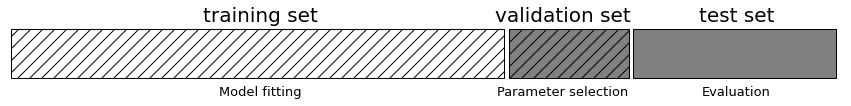

In [3]:
import mglearn
mglearn.plots.plot_threefold_split()

In [4]:
from sklearn.svm import SVC
# 将数据划分为训练+验证集与测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# 将训练+验证集划分为训练集与验证集
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 对每种参数组合都训练一个SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 在验证集上评估SVC
        score = svm.score(X_valid, y_valid)
        # 如果我们得到了更高的分数，则保存该分数和对应的参数
        if score > best_score:
           best_score = score
           best_parameters = {'C': C, 'gamma': gamma}
# 在训练+验证集上重新构建一个模型，并在测试集上进行评估
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


#### 带交叉验证的网格搜索

#### 使用交叉验证的主要缺点就是训练所有这些模型所需花费的时间

In [5]:
from sklearn.model_selection import cross_val_score

In [6]:
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 对于每种参数组合都训练一个SVC
        svm = SVC(gamma=gamma, C=C)
        # 执行交叉验证
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # 计算交叉验证平均精度
        score = np.mean(scores)
        # 如果我们得到了更高的分数，则保存该分数和对应的参数
        if score > best_score:
            best_score = score
            print("best_score: {:.2f}, gamma: {}, C: {}".format(best_score, gamma, C))
            best_parameters = {'C': C, 'gamma': gamma}
# 在训练+验证集上重新构建一个模型
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

best_score: 0.37, gamma: 0.001, C: 0.001
best_score: 0.70, gamma: 0.001, C: 1
best_score: 0.94, gamma: 0.001, C: 10
best_score: 0.96, gamma: 0.001, C: 100
best_score: 0.96, gamma: 0.01, C: 100
best_score: 0.97, gamma: 0.1, C: 10


SVC(C=10, gamma=0.1)

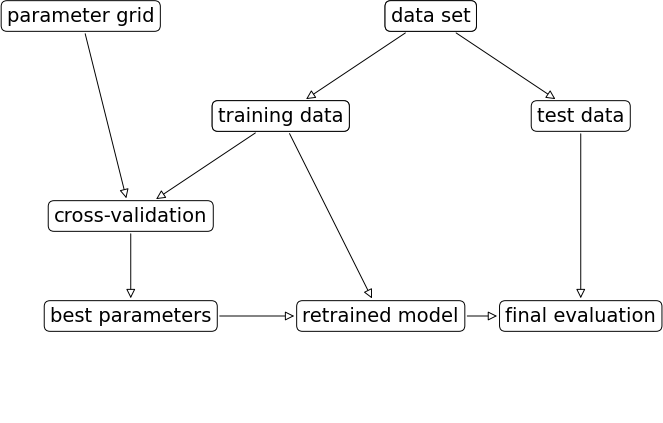

In [7]:
mglearn.plots.plot_grid_search_overview()

In [8]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [9]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

SVC(C=10, gamma=0.1)
{'C': 10, 'gamma': 0.1}
0.9731225296442687


In [10]:
results = pd.DataFrame(grid_search.cv_results_)
# 显示前5行
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001692,0.000761,0.000669,0.000560,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.002380,0.003050,0.000199,0.000399,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001015,0.000849,0.000406,0.000497,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.002947,0.002834,0.000408,0.000499,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.002544,0.002869,0.000200,0.000399,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


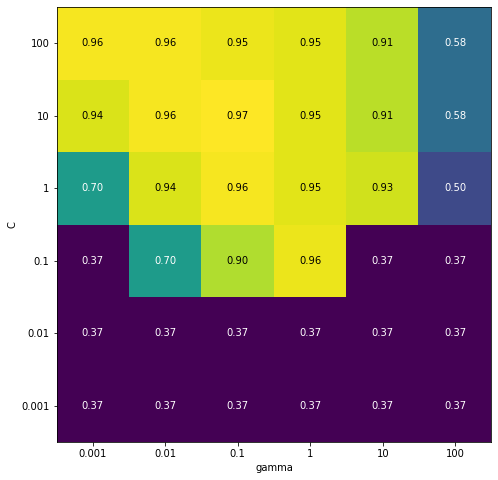

In [11]:
scores = np.array(results.mean_test_score).reshape(6, 6)

from matplotlib import pyplot as plt
# 对交叉验证平均分数作图
plt.figure(figsize=(14, 8))
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'])
plt.show()

In [12]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [13]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [14]:
results = pd.DataFrame(grid_search.cv_results_)
# 我们给出的是转置后的表格，这样更适合页面显示：
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00206,0.002064,0.000199,0.001622,0.0,0.000206,0.003193,0.003133,0.003125,0.0,...,0.00082,0.002353,0.002758,0.000663,0.002732,0.003203,0.000248,0.002115,0.000199,0.000528
std_fit_time,0.001232,0.003066,0.000399,0.003244,0.0,0.000412,0.006386,0.006267,0.006249,0.0,...,0.000766,0.003026,0.002818,0.000901,0.002889,0.002819,0.000401,0.003262,0.000399,0.000453
mean_score_time,0.000817,0.000895,0.002954,0.001632,0.0,0.0,0.000206,0.0,0.003124,0.0,...,0.000199,0.000443,0.0,0.001608,0.000563,0.0,0.000302,0.000207,0.000752,0.000545
std_score_time,0.000409,0.001347,0.003646,0.003264,0.0,0.0,0.000413,0.0,0.006249,0.0,...,0.000397,0.000546,0.0,0.003216,0.000729,0.0,0.000603,0.000413,0.001066,0.000465
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


In [15]:
param_grid

[{'kernel': ['rbf'],
  'C': [0.001, 0.01, 0.1, 1, 10, 100],
  'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
 {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [16]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668
